## DTW score

In [1]:
import numpy as np

def dtw_score(s, t):
    n, m = len(s), len(t)
    
    dtw = np.ones((n+1, m+1)) * np.inf
    dtw[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            dtw[i, j] = cost + np.min([
                dtw[i-1, j],    # insertion
                dtw[i, j-1],    # deletion
                dtw[i-1, j-1]   # match
            ])
    
    # dtw[i,j] is the distance between s[1:i] and t[1:j] with the best alignment
    return dtw[n, m]

In [2]:
from fastdtw import fastdtw

a = np.random.uniform(size=10)
b = np.random.uniform(size=15)

# Custom
print("Custom:", dtw_score(a, b))

# Fastdtw
distance, path = fastdtw(a, b)
print("Fastdtw:", distance)

Custom: 2.7584829731208615
Fastdtw: 2.7584829731208615


## DTW clustering without representatives

In [3]:
def gen_test_data():
    data = np.concatenate((
            np.random.normal((-2, -2), size=(200, 2)),
            np.random.normal((2, 2), size=(200, 2)),
            np.random.normal((-4, 4), size=(200, 2))
        ))
    np.random.shuffle(data)

    return data

In [4]:
from random import choice
import matplotlib.pyplot as plt

X = gen_test_data()

# Assign clusters randomly
nb_clust = 3
y = np.asarray([choice(range(nb_clust)) for _ in range(X.shape[0])])

In [5]:
# Assuming x is not in C
def dist_to_clust(x, C, mean=True):
    denom = len(C) if mean else 1
    dist = sum([dtw_score(x, ci) for ci in C])
    return dist / denom

rem = lambda A, i: np.delete(A, i, axis=0)

In [6]:
old_y = y.copy()

while True:
    for i, point in enumerate(X):
        curr_clust = y[i]
        best_clust = curr_clust
        best_score = np.inf

        for c in range(nb_clust):
            cluster = rem(X, i)[rem(y, i) == c]
            if (score := dist_to_clust(point, cluster)) < best_score:
                best_score = score
                best_clust = c
        
        y[i] = best_clust
    
    if (y == old_y).all():
        break
    old_y = y.copy()

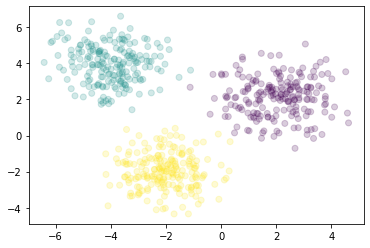

In [7]:
plt.scatter(X[:,0], X[:,1], alpha=0.2, c=y)

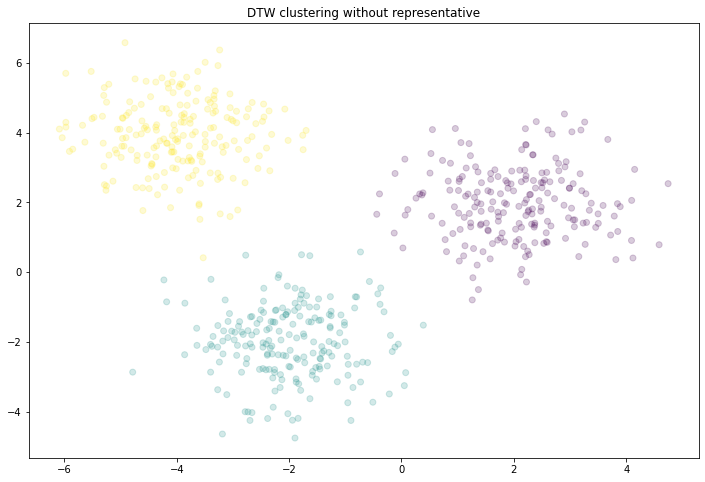

In [8]:
from matplotlib import animation


X = gen_test_data()

fig = plt.figure(figsize=(12, 8))
plt.title("DTW clustering without representative")

scatter = plt.scatter(X[:,0], X[:,1], alpha=0.2, c=y)


def animate(i):
    if i >= 600:
        i -= 600
    curr_clust = y[i]
    best_clust = curr_clust
    best_score = np.inf

    for c in range(nb_clust):
        cluster = rem(X, i)[rem(y, i) == c]
        if (score := dist_to_clust(X[i], cluster)) < best_score:
            best_score = score
            best_clust = c
    
    y[i] = best_clust
    scatter.set_array(y)

    return scatter,

anim = animation.FuncAnimation(fig, animate, frames=int(X.shape[0] * 1.5), interval=10, blit=True)
anim.save("images/dtw_anim.mp4")